# Proximal Policy Optimization

**Author:** [Ilias Chrysovergis](https://twitter.com/iliachry)<br>
**Date created:** 2021/06/24<br>
**Last modified:** 2021/06/24<br>
**Description:** Implementation of a Proximal Policy Optimization agent for the CartPole-v0 environment.

## Introduction

This code example solves the CartPole-v0 environment using a Proximal Policy Optimization (PPO) agent.

### CartPole-v0

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
The system is controlled by applying a force of +1 or -1 to the cart.
The pendulum starts upright, and the goal is to prevent it from falling over.
A reward of +1 is provided for every timestep that the pole remains upright.
The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.
After 200 steps the episode ends. Thus, the highest return we can get is equal to 200.

[CartPole-v0](https://gym.openai.com/envs/CartPole-v0/)

### Proximal Policy Optimization

PPO is a policy gradient method and can be used for environments with either discrete or continuous action spaces.
It trains a stochastic policy in an on-policy way. Also, it utilizes the actor critic method. The actor maps the
observation to an action and the critic gives an expectation of the rewards of the agent for the observation given.
Firstly, it collects a set of trajectories for each epoch by sampling from the latest version of the stochastic policy.
Then, the rewards-to-go and the advantage estimates are computed in order to update the policy and fit the value function.
The policy is updated via a stochastic gradient ascent optimizer, while the value function is fitted via some gradient descent algorithm.
This procedure is applied for many epochs until the environment is solved.

![Algorithm](https://i.imgur.com/rd5tda1.png)

- [PPO Original Paper](https://arxiv.org/pdf/1707.06347.pdf)
- [OpenAI Spinning Up docs - PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html)

### Note

This code example uses Keras and Tensorflow v2. It is based on the PPO Original Paper,
the OpenAI's Spinning Up docs for PPO, and the OpenAI's Spinning Up implementation of PPO using Tensorflow v1.

[OpenAI Spinning Up Github - PPO](https://github.com/openai/spinningup/blob/master/spinup/algos/tf1/ppo/ppo.py)

## Libraries

For this example the following libraries are used:

1. `numpy` for n-dimensional arrays
2. `tensorflow` and `keras` for building the deep RL PPO agent
3. `gym` for getting everything we need about the environment
4. `scipy.signal` for calculating the discounted cumulative sums of vectors

In [324]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import scipy.signal
import time
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext jupyternotify

## Functions and class

In [325]:

def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=tf.nn.relu, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)


def logprobabilities(logits, a):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = tf.nn.log_softmax(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability


# Sample action from actor
@tf.function
def sample_action(observation):
    logits = actor(observation)
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):

    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = tf.exp(
            logprobabilities(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(
            tf.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.reduce_mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer)
    )
    kl = tf.reduce_sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))


## Hyperparameters

In [326]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 500
epochs = 1000
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.95
target_kl = 0.01
hidden_sizes = (400, 300)

# True if you want to render the environment
render = False

In [322]:
def plot_euler_angles(t, roll, pitch, yaw, filename=None, bbox=(60,100,-1,1), inset=True):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title("Euler Angles")
    
    ax.plot(t, roll, label = 'roll', color = 'red')
    ax.plot(t, pitch, label = 'pitch', color = 'green')
    ax.plot(t, yaw, label = 'yaw', color = 'blue')
    
    if inset:
        ylims = ax.get_ylim()
        above = abs(ylims[1]) > abs(ylims[0])
        axins = ax.inset_axes([0.3, 0.55 if above else 0.05 , 0.5, 0.25])
        x1, x2, y1, y2 = bbox
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.plot(t, roll, label = 'roll', color = 'red')
        axins.plot(t, pitch, label = 'pitch', color = 'green')
        axins.plot(t, yaw, label = 'yaw', color = 'blue')
        axins.set_xticklabels([])
        ax.indicate_inset_zoom(axins, edgecolor="black")

    ax.set_ylabel(r'angles, [deg]')
    ax.set_xlabel(r't, [s]')
    ax.grid(True)
    ax.legend()
    fig.show()
    if filename is not None:
        fig.savefig(f'{filename}')

def plot_phase_diagram(roll, pitch, yaw, omega_, filename=None):
    fig2 = plt.figure(figsize=(8,8))
    ax2 = fig2.add_subplot(1,1,1)
    ax2.set_title("Phase diagram")
    ax2.plot(roll, omega_[0], label = 'roll', color = 'red')
    ax2.plot(pitch, omega_[1], label = 'pitch', color = 'green')
    ax2.plot(yaw, omega_[2], label = 'yaw', color = 'blue')
    ax2.plot([0],[0], 'o', markersize=8 , label='Destination', color = 'magenta')
    ax2.set_xlabel(r'$\alpha$')
    ax2.set_ylabel(r'$\omega$')
    ax2.legend()
    ax2.grid()
    fig2.show()
    if filename is not None:
        fig2.savefig(f'{filename}')

In [327]:
# Вспомогательные функции

def normalize(obj):

    return obj / np.linalg.norm(obj)


def cross_product(a, b):

    def check_dimensions(vec, string):

        if vec.ndim != 1:
            raise Exception("The {} input is not a vector".format(string))
        if len(vec) != 3:
            raise Exception("Wrong number of coordinates in the {0} vector: {1}, should be 3".format(string, len(vec)))

    check_dimensions(a, 'first')
    check_dimensions(b, 'second')

    return np.array([a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1] - a[1]*b[0]])

def quat_product(q1, q2):

    def check_dimensions(q, string):

        if q.ndim != 1:
            raise Exception("The {} input is not a quaternion".format(string))
        if len(q) != 4:
            raise Exception("Wrong number of coordinates in the {0} quaternion: {1}, should be 4".format(string, len(q)))

    check_dimensions(q1, 'first')
    check_dimensions(q2, 'second')

    q = np.zeros(4)
    q[0] = q1[0] * q2[0] - q1[1:].dot(q2[1:])
    q[1:] = q1[0] * q2[1:] + q2[0] * q1[1:] + cross_product(q1[1:], q2[1:])

    return q

def rotate_vec_with_quat(q, vec):

    def check_dimensions(obj, is_quat):

        if obj.ndim != 1:
            raise Exception("Not a {}".format('quaternion' * is_quat + 'vector' * (1 - is_quat)))
        if len(obj) != (3 + 1 * is_quat):
            raise Exception("Wrong number of coordinates in the {0}: {1}, should be {2}"
                            .format('quaternion' * is_quat + 'vector' * (1 - is_quat), len(obj), 3 + 1 * is_quat))

    check_dimensions(q, True)
    check_dimensions(vec, False)

    q = quat_conjugate(q)

    qxvec = cross_product(q[1:], vec)

    return q[1:].dot(vec) * q[1:] + q[0]**2. * vec + 2. * q[0] * qxvec + cross_product(q[1:], qxvec)

def quat2rpy(q0, q1, q2, q3):

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))

    return [roll, pitch, yaw]

def quat2rpy_deg(q0, q1, q2, q3):

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))*180/np.pi
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))*180/np.pi
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))*180/np.pi

    return [roll, pitch, yaw]

def quat_conjugate(q):

    q_new = np.copy(q)
    q_new[1:] = q_new[1:] * -1.

    return q_new

def gravity_gradient_torque(quat, inertia_tensor, mean_motion):
    Ae3 = rotate_vec_with_quat(quat, np.array([0., 0., 1.]))

    return 3. * mean_motion ** 2. * cross_product(Ae3, inertia_tensor.dot(Ae3))    


def rhs(t, x, sat, action):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:10]
     
    omega_rel = omega - rotate_vec_with_quat(quat, np.array([0., sat.mean_motion, 0.]))    
        
    trq_gg = gravity_gradient_torque(quat, sat.J, sat.mean_motion)       

    x_dot = np.zeros(10)
    action = action.reshape(3,)
    x_dot[0] = -0.5 * quat[1:].dot(omega_rel)
    x_dot[1:4] = 0.5 * (quat[0] * omega_rel + cross_product(quat[1:], omega_rel))
    tmp3 = (trq_gg + action - cross_product(omega, sat.J.dot(omega)))
    x_dot[4:7] = sat.J_inv.dot(tmp3)
    x_dot[7:10] = - action

    return x_dot

In [328]:
from types import SimpleNamespace
const = SimpleNamespace()
const.mu = 3.986e14
const.Re = 6037.1e3
sat = SimpleNamespace()
sat.J = np.diag(np.array([4, 5, 3]))
sat.J_inv = np.linalg.inv(sat.J)
sat.altitude = 600e3
sat.mean_motion = np.sqrt(const.mu / (const.Re + sat.altitude)**3.)


class TorqueDynamics(gym.Env):
  observation_space = gym.spaces.Box(-1, 1, shape=(10,))

  
  def __init__(self, dt, q_req, add_9=0.25):
    self.state = None
    self.dt = dt
    self.q_req = q_req
    self.q_req_conj = quat_conjugate(self.q_req)
    self.w_req = np.zeros(3)
    self.history = []
    self.t = []
    self.action_space = self.init_actions()
    self.q_prev = None
    self.add_9 = add_9

  @staticmethod
  def init_actions():
    a = np.linspace(-1, 1, 21)
    a1 = a/10
    a2 = a/100
    a = np.concatenate((a, a1, a2))
    a = np.unique(a.round(10))
    a = a[a>=-0.5]
    a = a[a<=0.5]

    s = a.shape
    a = np.vstack((a, np.zeros(s)))
    a = np.vstack((a, np.zeros(s)))
    a = a.T
    aroll1 = np.roll(a, 1)
    aroll2 = np.roll(a, 2)
    a = np.concatenate((a, aroll1))
    a = np.concatenate((a, aroll2))
    a = np.unique(a, axis=0)
    return a

  def reset(self, state=None):
    if state is not None:
      self.state = state
    else:
      self.state = self.observation_space.sample()
      phi = self.state[0] * np.pi 
      self.state[0] = np.cos(phi / 2)
      self.state[1:4] = normalize(self.state[1:4]) * np.sin(phi / 2)
      self.state[4:] = 0
    self.history = [self.state]
    self.t = [0]
    self.q_prev = self.state[:4]
    self.multiplier = 1
    return self.state

  @staticmethod
  def r_a(phi, q_current, q_prev):
    return np.exp(2-phi) if q_current > q_prev else np.exp(2-phi)/2


  def r_t(self, reward, phi):
    return reward + 9 if phi <= self.add_9 else reward

  def step(self, action):
    t0 = 0
    tf = self.dt
    x_0 = self.state
    if isinstance(action, int) or isinstance(action, np.int64):
      action = self.action_space[action].copy()
    
    action *= self.multiplier
    
    sol = solve_ivp(lambda t, x: rhs(t, x, sat, action), (t0,tf), x_0)#, t_eval=t_eval)
    x = sol.y.T
    t = sol.t[1:]
    observation = x[-1]
    observations = normalize(observation)
    time_ = self.t[-1] + self.dt
    self.state = observation
    self.history.append(observation)
    self.t.append(time_)

    # calculating rewards:
    q_current = observation[:4]
    q_error = quat_product(self.q_req_conj, q_current)
    q_error = np.clip(q_error, -1, 1)
    w_current = observation[4:7]
    #print('q_error', q_error)
    phi = 2*np.arccos(q_error[0])
    r_inter = self.r_a(phi, q_current[0], self.q_prev[0])
    r1 = self.r_t(r_inter, phi)
    # r2 = -np.sum(np.abs(observation[4:7]))
    # Qreward = np.exp(-0.1 * np.linalg.norm(q_current - self.q_req))
    # Wreward = np.exp(-0.1 * np.linalg.norm(w_current - self.w_req))
    # reward = Qreward * Wreward
    # reward = self.r_t(reward, phi)
    reward = r_inter #r1 #+ 10 * r2
    #print('rewards', r1, r2)
    
    self.multiplier = 1 if phi > np.pi/8 else np.sin(4*phi)
    
    self.q_prev = q_current

    q_req_ext = np.concatenate([self.q_req, self.w_req])
    done = np.linalg.norm(observation[:7] - q_req_ext) < 1e-4
    
    info = dict()
    info['x'] = self.history
    info['t'] = self.t
    return observation, reward, done, info
  
  def render(self):
    pass

## Initializations

In [329]:
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
env = TorqueDynamics(0.1, np.array([1, 0, 0, 0]), 0.05)
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], tf.nn.relu, None)
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(
    mlp(observation_input, list(hidden_sizes) + [1], tf.nn.relu, None), axis=1
)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)



## Train

In [330]:
def train(epochs, add_9, start=None):
# Iterate over the number of epochs
  print('starting training with', epochs, 'epochs')
  buffer = Buffer(observation_dimensions, steps_per_epoch)
  env = TorqueDynamics(0.1, np.array([1, 0, 0, 0]), add_9)
  # Initialize the observation, episode return and episode length
  observation, episode_return, episode_length = env.reset(start), 0, 0

  returns = []

  for epoch in range(epochs):
      # Initialize the sum of the returns, lengths and number of episodes for each epoch
      sum_return = 0
      sum_length = 0
      num_episodes = 0

      # Iterate over the steps of each epoch
      for t in range(steps_per_epoch):
          if render:
              env.render()

          # Get the logits, action, and take one step in the environment
          observation = observation.reshape(1, -1)
          logits, action = sample_action(observation)
          #print(type(action[0].numpy()))
          observation_new, reward, done, info = env.step(action[0].numpy())
          episode_return += reward
          episode_length += 1

          # Get the value and log-probability of the action
          value_t = critic(observation)
          logprobability_t = logprobabilities(logits, action)

          # Store obs, act, rew, v_t, logp_pi_t
          buffer.store(observation, action, reward, value_t, logprobability_t)

          # Update the observation
          observation = observation_new

          # Finish trajectory if reached to a terminal state
          terminal = done
          if terminal or (t == steps_per_epoch - 1):
              last_value = 0 if done else critic(observation.reshape(1, -1))
              buffer.finish_trajectory(last_value)
              sum_return += episode_return
              sum_length += episode_length
              num_episodes += 1
              observation, episode_return, episode_length = env.reset(start), 0, 0

      # Get values from the buffer
      (
          observation_buffer,
          action_buffer,
          advantage_buffer,
          return_buffer,
          logprobability_buffer,
      ) = buffer.get()

      # Update the policy and implement early stopping using KL divergence
      for _ in range(train_policy_iterations):
          kl = train_policy(
              observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
          )
          if kl > 1.5 * target_kl:
              # Early Stopping
              break

      # Update the value function
      for _ in range(train_value_iterations):
          train_value_function(observation_buffer, return_buffer)

      # Print mean return and length for each epoch
      print(
          f" Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}. Mean Length: {sum_length / num_episodes}"
      )
      returns.append(sum_return / num_episodes)
  return returns

In [107]:
# %%notify
print('Accounting for the gravity')
iterations = 20
reward_thresh = 0.1
tries = 100

for i in range(tries):
  print(f'Run #{i}. The "+9" threshold is {reward_thresh}')
  mean_ret = train(iterations, reward_thresh)
  mean_ret = np.min(mean_ret)
  print(f'Current batch mean is {mean_ret}')
  print('-'*10)
  if mean_ret > 5000 and reward_thresh > 0.004:
    reward_thresh *= 0.5# - 3*(mean_ret - 1000)/40000 # linear from (1000, 0.8) to (5000, 0.5)
  

Accounting for the gravity
Run #0. The "+9" threshold is 0.1
starting training with 20 epochs
 Epoch: 1. Mean Return: 2484.0711375201713. Mean Length: 500.0
 Epoch: 2. Mean Return: 2956.429222551612. Mean Length: 500.0
 Epoch: 3. Mean Return: 2161.9053587418202. Mean Length: 500.0
 Epoch: 4. Mean Return: 2721.2718969904354. Mean Length: 500.0
 Epoch: 5. Mean Return: 2826.017805761454. Mean Length: 500.0
 Epoch: 6. Mean Return: 2708.571264666454. Mean Length: 500.0
 Epoch: 7. Mean Return: 2514.239390069924. Mean Length: 500.0
 Epoch: 8. Mean Return: 2647.5757973672135. Mean Length: 500.0
 Epoch: 9. Mean Return: 2874.129046853963. Mean Length: 500.0
 Epoch: 10. Mean Return: 2592.751594805867. Mean Length: 500.0
 Epoch: 11. Mean Return: 2473.092176638701. Mean Length: 500.0
 Epoch: 12. Mean Return: 2666.2042025288374. Mean Length: 500.0
 Epoch: 13. Mean Return: 2899.6962749076106. Mean Length: 500.0
 Epoch: 14. Mean Return: 2510.7931530169426. Mean Length: 500.0
 Epoch: 15. Mean Return: 2

 Epoch: 1. Mean Return: 2976.221731522589. Mean Length: 500.0
 Epoch: 2. Mean Return: 2927.8902090496854. Mean Length: 500.0
 Epoch: 3. Mean Return: 2433.5688674723124. Mean Length: 500.0
 Epoch: 4. Mean Return: 2463.520673098442. Mean Length: 500.0
 Epoch: 5. Mean Return: 2833.3440138029882. Mean Length: 500.0
 Epoch: 6. Mean Return: 2482.2914600299123. Mean Length: 500.0
 Epoch: 7. Mean Return: 2845.096691139018. Mean Length: 500.0
 Epoch: 8. Mean Return: 2884.59549219987. Mean Length: 500.0
 Epoch: 9. Mean Return: 2886.9161489927305. Mean Length: 500.0
 Epoch: 10. Mean Return: 2589.2789316072035. Mean Length: 500.0
 Epoch: 11. Mean Return: 2995.898883345591. Mean Length: 500.0
 Epoch: 12. Mean Return: 2291.810991523926. Mean Length: 500.0
 Epoch: 13. Mean Return: 2463.2218370034534. Mean Length: 500.0
 Epoch: 14. Mean Return: 2580.8765370479996. Mean Length: 500.0
 Epoch: 15. Mean Return: 2246.1899263854693. Mean Length: 500.0
 Epoch: 16. Mean Return: 2972.1101605942818. Mean Length

 Epoch: 1. Mean Return: 2329.7028776166644. Mean Length: 500.0
 Epoch: 2. Mean Return: 2721.1948973791436. Mean Length: 500.0
 Epoch: 3. Mean Return: 2743.0339220046985. Mean Length: 500.0
 Epoch: 4. Mean Return: 2330.4711126336188. Mean Length: 500.0
 Epoch: 5. Mean Return: 2704.9755008418774. Mean Length: 500.0
 Epoch: 6. Mean Return: 2651.2095751466622. Mean Length: 500.0
 Epoch: 7. Mean Return: 2761.2713203114135. Mean Length: 500.0
 Epoch: 8. Mean Return: 2668.965677668357. Mean Length: 500.0
 Epoch: 9. Mean Return: 2466.2029999642205. Mean Length: 500.0
 Epoch: 10. Mean Return: 2887.6925412560963. Mean Length: 500.0
 Epoch: 11. Mean Return: 2657.385352867892. Mean Length: 500.0
 Epoch: 12. Mean Return: 2988.396499608755. Mean Length: 500.0
 Epoch: 13. Mean Return: 2557.303491486496. Mean Length: 500.0
 Epoch: 14. Mean Return: 2707.2684241324296. Mean Length: 500.0
 Epoch: 15. Mean Return: 2552.5348941310613. Mean Length: 500.0
 Epoch: 16. Mean Return: 2972.3686475892223. Mean Len

 Epoch: 1. Mean Return: 2730.0653237432416. Mean Length: 500.0
 Epoch: 2. Mean Return: 2692.1476498323095. Mean Length: 500.0
 Epoch: 3. Mean Return: 2762.1979366815517. Mean Length: 500.0
 Epoch: 4. Mean Return: 2793.38469166853. Mean Length: 500.0
 Epoch: 5. Mean Return: 2733.608555210932. Mean Length: 500.0
 Epoch: 6. Mean Return: 2956.1093557893923. Mean Length: 500.0
 Epoch: 7. Mean Return: 2315.0263209685927. Mean Length: 500.0
 Epoch: 8. Mean Return: 2808.2237002499146. Mean Length: 500.0
 Epoch: 9. Mean Return: 2784.123507465593. Mean Length: 500.0
 Epoch: 10. Mean Return: 2658.525411595536. Mean Length: 500.0
 Epoch: 11. Mean Return: 2758.152484681465. Mean Length: 500.0
 Epoch: 12. Mean Return: 2753.113746084733. Mean Length: 500.0
 Epoch: 13. Mean Return: 2929.1545036032353. Mean Length: 500.0
 Epoch: 14. Mean Return: 3088.381783736902. Mean Length: 500.0
 Epoch: 15. Mean Return: 2534.4486371253697. Mean Length: 500.0
 Epoch: 16. Mean Return: 2842.7493678961537. Mean Length:

 Epoch: 1. Mean Return: 2337.362698002471. Mean Length: 500.0
 Epoch: 2. Mean Return: 2194.8391933529974. Mean Length: 500.0
 Epoch: 3. Mean Return: 2513.331330251924. Mean Length: 500.0
 Epoch: 4. Mean Return: 2735.0014919102737. Mean Length: 500.0
 Epoch: 5. Mean Return: 2817.959629737681. Mean Length: 500.0
 Epoch: 6. Mean Return: 2708.0183553737147. Mean Length: 500.0
 Epoch: 7. Mean Return: 2623.03505473317. Mean Length: 500.0
 Epoch: 8. Mean Return: 2808.4270869598467. Mean Length: 500.0
 Epoch: 9. Mean Return: 2846.4512630770514. Mean Length: 500.0
 Epoch: 10. Mean Return: 2549.5816329881823. Mean Length: 500.0
 Epoch: 11. Mean Return: 2346.234024870323. Mean Length: 500.0
 Epoch: 12. Mean Return: 2965.2580116587897. Mean Length: 500.0
 Epoch: 13. Mean Return: 2814.587167499858. Mean Length: 500.0
 Epoch: 14. Mean Return: 2934.5470632377455. Mean Length: 500.0
 Epoch: 15. Mean Return: 3140.9922278367353. Mean Length: 500.0
 Epoch: 16. Mean Return: 2490.922864426509. Mean Length:

 Epoch: 1. Mean Return: 2617.090487699668. Mean Length: 500.0
 Epoch: 2. Mean Return: 2401.0275828666863. Mean Length: 500.0
 Epoch: 3. Mean Return: 2907.545647375955. Mean Length: 500.0
 Epoch: 4. Mean Return: 2755.1610357968357. Mean Length: 500.0
 Epoch: 5. Mean Return: 2294.9848170668793. Mean Length: 500.0
 Epoch: 6. Mean Return: 2786.337321617992. Mean Length: 500.0
 Epoch: 7. Mean Return: 2875.101930049784. Mean Length: 500.0
 Epoch: 8. Mean Return: 2159.0811554248053. Mean Length: 500.0
 Epoch: 9. Mean Return: 2940.297307866334. Mean Length: 500.0
 Epoch: 10. Mean Return: 2883.6442793140504. Mean Length: 500.0
 Epoch: 11. Mean Return: 2528.0831523045304. Mean Length: 500.0
 Epoch: 12. Mean Return: 2625.881101037714. Mean Length: 500.0
 Epoch: 13. Mean Return: 2562.686734660483. Mean Length: 500.0
 Epoch: 14. Mean Return: 2627.5648909630504. Mean Length: 500.0
 Epoch: 15. Mean Return: 2658.6705730125555. Mean Length: 500.0
 Epoch: 16. Mean Return: 2767.5906868425022. Mean Length

 Epoch: 1. Mean Return: 2622.804556622353. Mean Length: 500.0
 Epoch: 2. Mean Return: 2978.9946584949457. Mean Length: 500.0
 Epoch: 3. Mean Return: 2036.8983777279193. Mean Length: 500.0
 Epoch: 4. Mean Return: 2234.6305703458384. Mean Length: 500.0
 Epoch: 5. Mean Return: 2345.7129971277564. Mean Length: 500.0
 Epoch: 6. Mean Return: 2648.163680481328. Mean Length: 500.0
 Epoch: 7. Mean Return: 2573.638493755855. Mean Length: 500.0
 Epoch: 8. Mean Return: 2029.6523403260765. Mean Length: 500.0
 Epoch: 9. Mean Return: 2862.412040166813. Mean Length: 500.0
 Epoch: 10. Mean Return: 2602.476080740758. Mean Length: 500.0
 Epoch: 11. Mean Return: 2740.4889010770776. Mean Length: 500.0
 Epoch: 12. Mean Return: 2724.615314725348. Mean Length: 500.0
 Epoch: 13. Mean Return: 2600.7412618966005. Mean Length: 500.0
 Epoch: 14. Mean Return: 2415.081325282919. Mean Length: 500.0
 Epoch: 15. Mean Return: 2802.3424792266937. Mean Length: 500.0
 Epoch: 16. Mean Return: 2778.8372041537873. Mean Length

 Epoch: 1. Mean Return: 2541.7370815838954. Mean Length: 500.0
 Epoch: 2. Mean Return: 2275.01708148781. Mean Length: 500.0
 Epoch: 3. Mean Return: 2572.337833362759. Mean Length: 500.0
 Epoch: 4. Mean Return: 2866.6358322327665. Mean Length: 500.0
 Epoch: 5. Mean Return: 3019.682872719181. Mean Length: 500.0
 Epoch: 6. Mean Return: 2615.1520015087967. Mean Length: 500.0
 Epoch: 7. Mean Return: 2697.873274921123. Mean Length: 500.0
 Epoch: 8. Mean Return: 2424.9992188507595. Mean Length: 500.0
 Epoch: 9. Mean Return: 2609.775190619237. Mean Length: 500.0
 Epoch: 10. Mean Return: 2840.7318247267253. Mean Length: 500.0
 Epoch: 11. Mean Return: 2839.386808441769. Mean Length: 500.0
 Epoch: 12. Mean Return: 2890.0945943716306. Mean Length: 500.0
 Epoch: 13. Mean Return: 2583.2482824189815. Mean Length: 500.0
 Epoch: 14. Mean Return: 2872.062808251673. Mean Length: 500.0
 Epoch: 15. Mean Return: 2942.5644425885175. Mean Length: 500.0
 Epoch: 16. Mean Return: 2682.32033455087. Mean Length: 5

 Epoch: 1. Mean Return: 2983.101586799352. Mean Length: 500.0
 Epoch: 2. Mean Return: 2569.5638381966387. Mean Length: 500.0
 Epoch: 3. Mean Return: 2604.7676169069323. Mean Length: 500.0
 Epoch: 4. Mean Return: 2540.6864538141513. Mean Length: 500.0
 Epoch: 5. Mean Return: 2673.7808148472946. Mean Length: 500.0
 Epoch: 6. Mean Return: 2698.2658701991654. Mean Length: 500.0
 Epoch: 7. Mean Return: 2676.850471229609. Mean Length: 500.0
 Epoch: 8. Mean Return: 2377.4142176120467. Mean Length: 500.0
 Epoch: 9. Mean Return: 2506.578123831536. Mean Length: 500.0
 Epoch: 10. Mean Return: 2865.984628448675. Mean Length: 500.0
 Epoch: 11. Mean Return: 2720.2766464449505. Mean Length: 500.0
 Epoch: 12. Mean Return: 2963.8075271082475. Mean Length: 500.0
 Epoch: 13. Mean Return: 2461.9126735476993. Mean Length: 500.0
 Epoch: 14. Mean Return: 2792.980144815013. Mean Length: 500.0
 Epoch: 15. Mean Return: 2499.855756357289. Mean Length: 500.0
 Epoch: 16. Mean Return: 2756.6364604670985. Mean Lengt

 Epoch: 1. Mean Return: 2482.7547161671405. Mean Length: 500.0
 Epoch: 2. Mean Return: 2859.0080193016693. Mean Length: 500.0
 Epoch: 3. Mean Return: 2773.375231577164. Mean Length: 500.0
 Epoch: 4. Mean Return: 2514.4290102943264. Mean Length: 500.0
 Epoch: 5. Mean Return: 2997.256143985576. Mean Length: 500.0
 Epoch: 6. Mean Return: 2702.172648328865. Mean Length: 500.0
 Epoch: 7. Mean Return: 2886.9647777484925. Mean Length: 500.0
 Epoch: 8. Mean Return: 2821.1737840606656. Mean Length: 500.0
 Epoch: 9. Mean Return: 2702.8536719201666. Mean Length: 500.0
 Epoch: 10. Mean Return: 2871.987491075472. Mean Length: 500.0
 Epoch: 11. Mean Return: 2307.662551774667. Mean Length: 500.0
 Epoch: 12. Mean Return: 2872.277735647587. Mean Length: 500.0
 Epoch: 13. Mean Return: 2432.2511363908784. Mean Length: 500.0
 Epoch: 14. Mean Return: 2798.5669909894223. Mean Length: 500.0
 Epoch: 15. Mean Return: 2414.4645192868693. Mean Length: 500.0
 Epoch: 16. Mean Return: 2792.511647732864. Mean Length

 Epoch: 1. Mean Return: 2582.9902867671703. Mean Length: 500.0
 Epoch: 2. Mean Return: 2759.327664941057. Mean Length: 500.0
 Epoch: 3. Mean Return: 2567.567249056353. Mean Length: 500.0
 Epoch: 4. Mean Return: 2830.2833229224875. Mean Length: 500.0
 Epoch: 5. Mean Return: 2806.414080957929. Mean Length: 500.0
 Epoch: 6. Mean Return: 2804.8743361772413. Mean Length: 500.0
 Epoch: 7. Mean Return: 2732.1353029876605. Mean Length: 500.0
 Epoch: 8. Mean Return: 2597.4704397433925. Mean Length: 500.0
 Epoch: 9. Mean Return: 2674.4935675045626. Mean Length: 500.0
 Epoch: 10. Mean Return: 2756.1876043042544. Mean Length: 500.0
 Epoch: 11. Mean Return: 2734.74955171509. Mean Length: 500.0
 Epoch: 12. Mean Return: 2793.5298227641997. Mean Length: 500.0
 Epoch: 13. Mean Return: 2836.94864462281. Mean Length: 500.0
 Epoch: 14. Mean Return: 2637.031150891894. Mean Length: 500.0
 Epoch: 15. Mean Return: 2708.3714907278018. Mean Length: 500.0
 Epoch: 16. Mean Return: 2859.873403530753. Mean Length: 

 Epoch: 1. Mean Return: 2740.3586387379764. Mean Length: 500.0
 Epoch: 2. Mean Return: 2640.328960434235. Mean Length: 500.0
 Epoch: 3. Mean Return: 2621.803957640077. Mean Length: 500.0
 Epoch: 4. Mean Return: 2979.122203715963. Mean Length: 500.0
 Epoch: 5. Mean Return: 2432.7785729351554. Mean Length: 500.0
 Epoch: 6. Mean Return: 2922.049279752485. Mean Length: 500.0
 Epoch: 7. Mean Return: 2956.0092070945134. Mean Length: 500.0
 Epoch: 8. Mean Return: 2511.746068028567. Mean Length: 500.0
 Epoch: 9. Mean Return: 2816.2487872415177. Mean Length: 500.0
 Epoch: 10. Mean Return: 2798.403212859613. Mean Length: 500.0
 Epoch: 11. Mean Return: 2483.1940193788196. Mean Length: 500.0
 Epoch: 12. Mean Return: 2677.7347310491323. Mean Length: 500.0
 Epoch: 13. Mean Return: 2784.8560766293704. Mean Length: 500.0
 Epoch: 14. Mean Return: 2893.7202795131448. Mean Length: 500.0
 Epoch: 15. Mean Return: 2745.1288528566038. Mean Length: 500.0
 Epoch: 16. Mean Return: 2949.0249268360644. Mean Lengt

 Epoch: 1. Mean Return: 2428.0365231956803. Mean Length: 500.0
 Epoch: 2. Mean Return: 2749.5553195109196. Mean Length: 500.0
 Epoch: 3. Mean Return: 2701.218745169363. Mean Length: 500.0
 Epoch: 4. Mean Return: 2833.1357430743205. Mean Length: 500.0
 Epoch: 5. Mean Return: 2889.685789535761. Mean Length: 500.0
 Epoch: 6. Mean Return: 2827.951875632384. Mean Length: 500.0
 Epoch: 7. Mean Return: 2489.290060459588. Mean Length: 500.0
 Epoch: 8. Mean Return: 2980.151962881132. Mean Length: 500.0
 Epoch: 9. Mean Return: 2816.2647434147398. Mean Length: 500.0
 Epoch: 10. Mean Return: 2827.7155790191887. Mean Length: 500.0
 Epoch: 11. Mean Return: 2912.909464852384. Mean Length: 500.0
 Epoch: 12. Mean Return: 2953.244274914866. Mean Length: 500.0
 Epoch: 13. Mean Return: 3058.779861959104. Mean Length: 500.0
 Epoch: 14. Mean Return: 2517.4468696527124. Mean Length: 500.0
 Epoch: 15. Mean Return: 2577.3042555449333. Mean Length: 500.0
 Epoch: 16. Mean Return: 2696.7723059744812. Mean Length:

 Epoch: 1. Mean Return: 2680.5616233779992. Mean Length: 500.0
 Epoch: 2. Mean Return: 2637.067774440593. Mean Length: 500.0
 Epoch: 3. Mean Return: 2478.4785636413903. Mean Length: 500.0
 Epoch: 4. Mean Return: 2414.9070372420097. Mean Length: 500.0
 Epoch: 5. Mean Return: 2624.2127082296697. Mean Length: 500.0
 Epoch: 6. Mean Return: 2534.9549225389283. Mean Length: 500.0
 Epoch: 7. Mean Return: 3148.0190339957862. Mean Length: 500.0
 Epoch: 8. Mean Return: 2596.886356896. Mean Length: 500.0
 Epoch: 9. Mean Return: 2977.6594176921794. Mean Length: 500.0
 Epoch: 10. Mean Return: 2952.160274229071. Mean Length: 500.0
 Epoch: 11. Mean Return: 2643.761212100353. Mean Length: 500.0
 Epoch: 12. Mean Return: 2572.667132379598. Mean Length: 500.0
 Epoch: 13. Mean Return: 2857.0847436943563. Mean Length: 500.0
 Epoch: 14. Mean Return: 2573.782255601739. Mean Length: 500.0
 Epoch: 15. Mean Return: 3045.277620092985. Mean Length: 500.0
 Epoch: 16. Mean Return: 2420.3425213414575. Mean Length: 5

 Epoch: 1. Mean Return: 2892.676460949443. Mean Length: 500.0
 Epoch: 2. Mean Return: 2267.488072281379. Mean Length: 500.0
 Epoch: 3. Mean Return: 3022.478514826404. Mean Length: 500.0
 Epoch: 4. Mean Return: 2905.3349785729774. Mean Length: 500.0
 Epoch: 5. Mean Return: 2412.5698010732485. Mean Length: 500.0
 Epoch: 6. Mean Return: 2749.3878180366505. Mean Length: 500.0
 Epoch: 7. Mean Return: 2735.7487608305028. Mean Length: 500.0
 Epoch: 8. Mean Return: 2786.982761521083. Mean Length: 500.0
 Epoch: 9. Mean Return: 2860.726128092638. Mean Length: 500.0
 Epoch: 10. Mean Return: 2666.9674018308406. Mean Length: 500.0
 Epoch: 11. Mean Return: 2965.9408984462084. Mean Length: 500.0
 Epoch: 12. Mean Return: 2497.146263078229. Mean Length: 500.0
 Epoch: 13. Mean Return: 2783.185683914465. Mean Length: 500.0
 Epoch: 14. Mean Return: 2584.489039422404. Mean Length: 500.0
 Epoch: 15. Mean Return: 3057.702980993112. Mean Length: 500.0
 Epoch: 16. Mean Return: 2748.4249132065383. Mean Length: 

 Epoch: 1. Mean Return: 2996.267559201902. Mean Length: 500.0
 Epoch: 2. Mean Return: 2541.2104201607926. Mean Length: 500.0
 Epoch: 3. Mean Return: 2474.550464339074. Mean Length: 500.0
 Epoch: 4. Mean Return: 2813.2266401020684. Mean Length: 500.0
 Epoch: 5. Mean Return: 2512.4390136784755. Mean Length: 500.0
 Epoch: 6. Mean Return: 2583.8767806687943. Mean Length: 500.0
 Epoch: 7. Mean Return: 2855.8480411368428. Mean Length: 500.0
 Epoch: 8. Mean Return: 2866.636784358602. Mean Length: 500.0
 Epoch: 9. Mean Return: 3020.703102829694. Mean Length: 500.0
 Epoch: 10. Mean Return: 2934.7787576910623. Mean Length: 500.0
 Epoch: 11. Mean Return: 2903.7185293952825. Mean Length: 500.0
 Epoch: 12. Mean Return: 2736.537193116723. Mean Length: 500.0
 Epoch: 13. Mean Return: 2539.149801208675. Mean Length: 500.0
 Epoch: 14. Mean Return: 3143.268264957895. Mean Length: 500.0
 Epoch: 15. Mean Return: 3029.0247907590715. Mean Length: 500.0
 Epoch: 16. Mean Return: 3008.938499075992. Mean Length:

 Epoch: 1. Mean Return: 3033.3973740362767. Mean Length: 500.0
 Epoch: 2. Mean Return: 2501.5741411624144. Mean Length: 500.0
 Epoch: 3. Mean Return: 2868.0664155092936. Mean Length: 500.0
 Epoch: 4. Mean Return: 2562.507754806455. Mean Length: 500.0
 Epoch: 5. Mean Return: 2814.7740471140996. Mean Length: 500.0
 Epoch: 6. Mean Return: 2760.9510580819106. Mean Length: 500.0
 Epoch: 7. Mean Return: 2995.3658955384167. Mean Length: 500.0
 Epoch: 8. Mean Return: 2937.7232079577393. Mean Length: 500.0
 Epoch: 9. Mean Return: 2610.102432118603. Mean Length: 500.0
 Epoch: 10. Mean Return: 2543.8285787322925. Mean Length: 500.0
 Epoch: 11. Mean Return: 2978.474052022713. Mean Length: 500.0
 Epoch: 12. Mean Return: 2956.7075254408414. Mean Length: 500.0
 Epoch: 13. Mean Return: 2572.5351452196333. Mean Length: 500.0
 Epoch: 14. Mean Return: 2964.0614046502706. Mean Length: 500.0
 Epoch: 15. Mean Return: 2881.7236856179184. Mean Length: 500.0
 Epoch: 16. Mean Return: 2782.7503890004746. Mean Le

<IPython.core.display.Javascript object>

In [337]:
# %%notify
observation = env.reset()
episode_return = 0
# Iterate over the steps of each epoch
for t in range(steps_per_epoch*2):
    if render:
        env.render()

    # Get the logits, action, and take one step in the environment
    observation = observation.reshape(1, -1)
    logits, action = sample_action(observation)
    #print(type(action[0].numpy()))
    observation_new, reward, done, info = env.step(action[0].numpy())
    episode_return += reward

    # Update the observation
    observation = observation_new
print(episode_return)

580.8505097894697


-1.6578280023967897
-7.96913067019653
11.863435118067962
17.665890457565844
25.214670863493083
38.58261738499197


C:\Users\imjob\AppData\Local\Temp/ipykernel_11260/3279205647.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


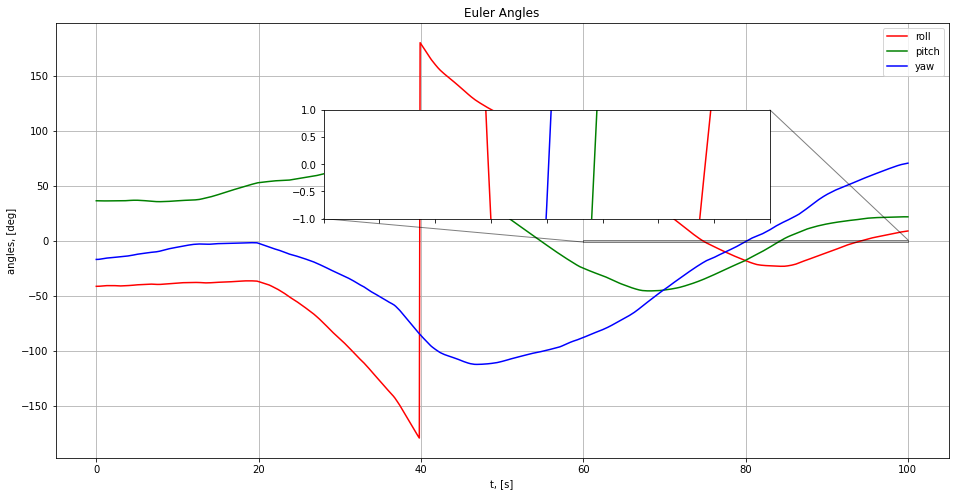

In [338]:
x = np.array(info['x'])
t = np.array(info['t'])
roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
size = roll.shape[0]//3
print(np.mean(roll[-size:]))
print(np.mean(pitch[-size:]))
print(np.mean(yaw[-size:]))
print(np.std(roll[-size:]))
print(np.std(pitch[-size:]))
print(np.std(yaw[-size:]))

plot_euler_angles(t, roll, pitch, yaw, 'angles2.pdf')

In [110]:
start = np.array([np.cos(np.pi/2),0,0,np.sin(np.pi/2),0,0,0,0,0,0])

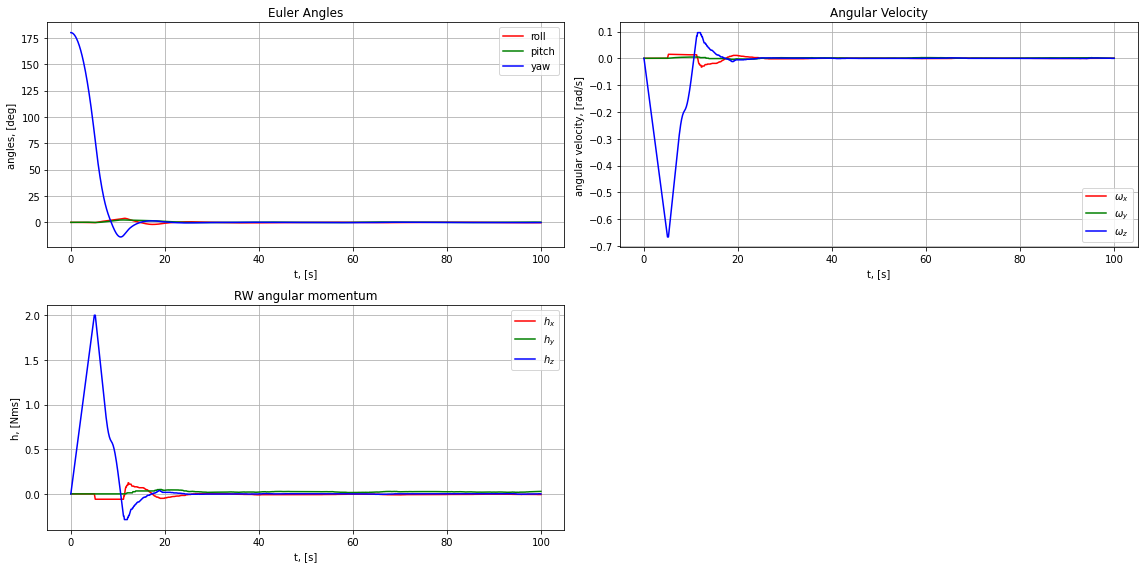

In [92]:
roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
   
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(2,2,1)

ax1.set_title("Euler Angles")
ax1.plot(t, roll, label = 'roll', color = 'red')
ax1.plot(t, pitch, label = 'pitch', color = 'green')
ax1.plot(t, yaw, label = 'yaw', color = 'blue')
ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2,2,2)

ax2.set_title("Angular Velocity")
ax2.plot(t, x[:,4], label = '$\omega_x$', color = 'red')
ax2.plot(t, x[:,5], label = '$\omega_y$', color = 'green')
ax2.plot(t, x[:,6], label = '$\omega_z$', color = 'blue')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax2 = fig1.add_subplot(2,2,3)

ax2.set_title("RW angular momentum")
ax2.plot(t, x[:,7], label = '$h_x$', color = 'red')
ax2.plot(t, x[:,8], label = '$h_y$', color = 'green')
ax2.plot(t, x[:,9], label = '$h_z$', color = 'blue')
ax2.set_ylabel(r'h, [Nms]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

## Saving the weights

In [119]:
actor_config = actor.get_config()
actor_weights = actor.get_weights()
critic_config = critic.get_config()
critic_weights = critic.get_weights()
import pickle
name = f'configs_weights_sin{iterations} {reward_thresh}.pickle'
with open(name, 'wb') as f:
  pickle.dump((actor_config, actor_weights, critic_config, critic_weights), f)

## Importing the weights

In [336]:
import pickle
# iterations = 1500
# reward_thresh = 0.0043
name = f'data/configs_weights_sin_better.pickle'
with open(name, 'rb') as f:
    something = pickle.load(f)

actor_config, actor_weights ,critic_config, critic_weights = something
actor = keras.Model.from_config(actor_config)
actor.set_weights(actor_weights)
critic = keras.Model.from_config(critic_config)
critic.set_weights(critic_weights)

In [70]:
env.action_space

array([[-0.5  ,  0.   ,  0.   ],
       [-0.4  ,  0.   ,  0.   ],
       [-0.3  ,  0.   ,  0.   ],
       [-0.2  ,  0.   ,  0.   ],
       [-0.1  ,  0.   ,  0.   ],
       [-0.09 ,  0.   ,  0.   ],
       [-0.08 ,  0.   ,  0.   ],
       [-0.07 ,  0.   ,  0.   ],
       [-0.06 ,  0.   ,  0.   ],
       [-0.05 ,  0.   ,  0.   ],
       [-0.04 ,  0.   ,  0.   ],
       [-0.03 ,  0.   ,  0.   ],
       [-0.02 ,  0.   ,  0.   ],
       [-0.01 ,  0.   ,  0.   ],
       [-0.009,  0.   ,  0.   ],
       [-0.008,  0.   ,  0.   ],
       [-0.007,  0.   ,  0.   ],
       [-0.006,  0.   ,  0.   ],
       [-0.005,  0.   ,  0.   ],
       [-0.004,  0.   ,  0.   ],
       [-0.003,  0.   ,  0.   ],
       [-0.002,  0.   ,  0.   ],
       [-0.001,  0.   ,  0.   ],
       [ 0.   , -0.5  ,  0.   ],
       [ 0.   , -0.4  ,  0.   ],
       [ 0.   , -0.3  ,  0.   ],
       [ 0.   , -0.2  ,  0.   ],
       [ 0.   , -0.1  ,  0.   ],
       [ 0.   , -0.09 ,  0.   ],
       [ 0.   , -0.08 ,  0.   ],
       [ 0